In [1]:
## %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [2]:
import podspy.log, json
import itertools as itls

In [3]:
TRACE_STATS_ENRICHED_FILENAME = 'trace-stats-enriched.csv'
TRACE_STATS_FILENAME = 'trace-stats.csv'
CONFIGS_JSON_FILENAME = 'configs.json'
REPLAY_ID = 'replay_id'
ALIGNMENT_FILENAME = 'alignments.json'
ALIGNMENT_FPATH = 'alignment_fpath'

# things to ignore from configs
OUTFILE_KEY = 'outFile'
RESULTDIR_KEY = 'resultDir'
LOGPATH_KEY = 'logPath'
MODELPATH_KEY = 'modelPath'
TO_IGNORE_KEY_LIST = [
    OUTFILE_KEY, 
    RESULTDIR_KEY,
    LOGPATH_KEY,
    MODELPATH_KEY
]


def mono_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_ENRICHED_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_fpath = os.path.join(replay_dirpath, ALIGNMENT_FILENAME)
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    trace_stats_df[ALIGNMENT_FPATH] = alignment_fpath
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
        
    return trace_stats_df


def reco_read_trace_stats(replay_id, replay_dirpath):
    trace_stats_fpath = os.path.join(replay_dirpath, TRACE_STATS_FILENAME)
    configs_fpath = os.path.join(replay_dirpath, CONFIGS_JSON_FILENAME)
    alignment_fpath = os.path.join(replay_dirpath, ALIGNMENT_FILENAME)
    
    with open(configs_fpath, 'r') as f:
        configs_dict = json.load(f)
        
    for key in TO_IGNORE_KEY_LIST:
        del configs_dict[key]
        
    trace_stats_df = pd.read_csv(trace_stats_fpath)
    trace_stats_df[REPLAY_ID] = replay_id
    trace_stats_df[ALIGNMENT_FPATH] = alignment_fpath
    
    for key, item in configs_dict.items():
        trace_stats_df[key] = item
        
    return trace_stats_df

### A* star results

In [4]:
mono_astar_basedir = '../../results-agg/clst_2018_12/2018-12-11_06-46-11-339718_BPI2018-net1-nILP-inc3-mono'
reco_sese_astar_basedir = '../../results-agg/clst_2018_12/2018-12-25_07-10-36-499180_BPI2018-net1-nILP-inc3-sese_25-score-strict'
reco_gene_astar_basedir = '../../results-agg/clst_2018_12/2018-12-26_02-24-47-110351_BPI2018-net1-nILP-inc3-generic_50-score-strict'

mono_astar_stats_df_list = []
reco_sese_astar_stats_df_list = []
reco_gene_astar_stats_df_list = []

for d in os.listdir(mono_astar_basedir):
    replay_dirpath = os.path.join(mono_astar_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = mono_read_trace_stats(d, replay_dirpath)
    mono_astar_stats_df_list.append(trace_stats_df)
    
for d in os.listdir(reco_sese_astar_basedir):
    replay_dirpath = os.path.join(reco_sese_astar_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = reco_read_trace_stats(d, replay_dirpath)
    reco_sese_astar_stats_df_list.append(trace_stats_df)

for d in os.listdir(reco_gene_astar_basedir):
    replay_dirpath = os.path.join(reco_gene_astar_basedir, d)
    if not os.path.isdir(replay_dirpath):
        continue
        
    trace_stats_df = reco_read_trace_stats(d, replay_dirpath)
    reco_gene_astar_stats_df_list.append(trace_stats_df)    
    
mono_astar_stats_df = pd.concat(mono_astar_stats_df_list, axis=0)
reco_sese_astar_stats_df = pd.concat(reco_sese_astar_stats_df_list, axis=0)
reco_gene_astar_stats_df = pd.concat(reco_gene_astar_stats_df_list, axis=0)

# merge the recomposing results with the monolithic results
merge_on = [REPLAY_ID, 'SP label']
suffixes = ('_mono', '_reco')

sese_astar_stats_df = mono_astar_stats_df.merge(reco_sese_astar_stats_df, on=merge_on, suffixes=suffixes)
gene_astar_stats_df = mono_astar_stats_df.merge(reco_gene_astar_stats_df, on=merge_on, suffixes=suffixes)

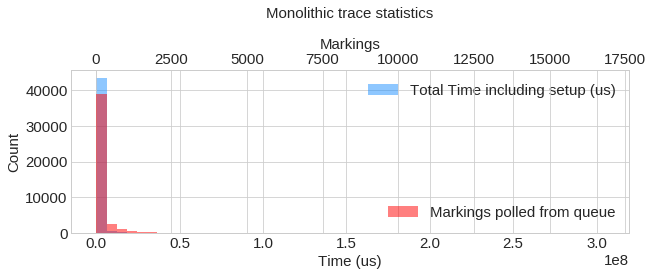

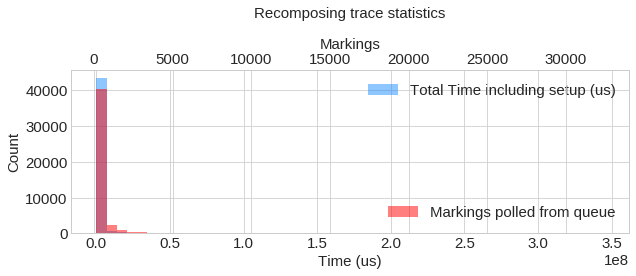

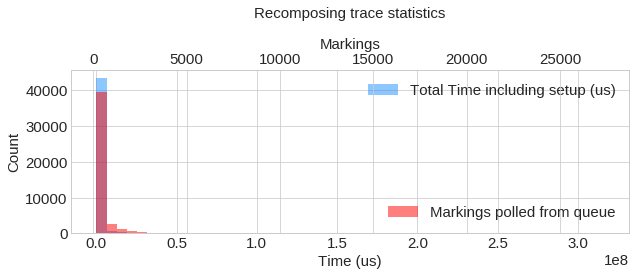

In [5]:
def plot_hist_time_vs_marking(df, title, ylim=None):
    fig, ax = plt.subplots(figsize=(10, 3))
    
    ax.hist(df['Total Time including setup (us)'], bins=50, alpha=0.5, color='dodgerblue')
    ax_twin = ax.twiny()
    ax_twin.hist(df['Markings polled from queue'], bins=50, alpha=0.5, color='red')
    
    ax.set_ylabel('Count')
    ax.set_xlabel('Time (us)')
    ax_twin.set_xlabel('Markings')
    ax.set_title(title, pad=20, size=15)
    
    ax.legend(loc=1)
    ax_twin.legend(loc=4);
    
    if ylim is not None:
        ax.set_ylim(ylim);

plot_hist_time_vs_marking(mono_astar_stats_df, 'Monolithic trace statistics', ylim=None)
plot_hist_time_vs_marking(reco_sese_astar_stats_df, 'Recomposing trace statistics', ylim=None)
plot_hist_time_vs_marking(reco_gene_astar_stats_df, 'Recomposing trace statistics', ylim=None)

### Plot the binned count differences between total time and polled markings

In [6]:
# @todo

### Check time distribution between A* and LP

Mono alignment time percentage SD: 0.45
Reco sese alignment time percentage SD: 0.42
Reco generic alignment time percentage SD: 0.67


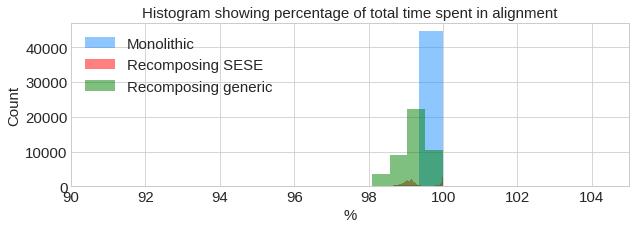

In [7]:
mono_astar_stats_df['align_time_perc'] = mono_astar_stats_df['Time to compute alignment (us)'] / mono_astar_stats_df['Total Time including setup (us)'] * 100.
reco_sese_astar_stats_df['align_time_perc'] = reco_sese_astar_stats_df['Time to compute alignment (us)'] / reco_sese_astar_stats_df['Total Time including setup (us)'] * 100.
reco_gene_astar_stats_df['align_time_perc'] = reco_gene_astar_stats_df['Time to compute alignment (us)'] / reco_gene_astar_stats_df['Total Time including setup (us)'] * 100.

fig, ax = plt.subplots(figsize=(10, 3))

ax.hist(mono_astar_stats_df['align_time_perc'], bins=100, alpha=0.5, color='dodgerblue')
ax.hist(reco_sese_astar_stats_df['align_time_perc'], bins=100, alpha=0.5, color='red')
ax.hist(reco_gene_astar_stats_df['align_time_perc'], bins=100, alpha=0.5, color='green')

ax.set_xlim([90, 105])

ax.legend()
# modify legend labels
lgd_texts = ax.legend().get_texts()
lgd_texts[0].set_text('Monolithic')
lgd_texts[1].set_text('Recomposing SESE')
lgd_texts[2].set_text('Recomposing generic')

ax.set_ylabel('Count')
ax.set_xlabel('%')
ax.set_title('Histogram showing percentage of total time spent in alignment', size=15);

print('Mono alignment time percentage SD: {:.2f}'.format(mono_astar_stats_df['align_time_perc'].std()))
print('Reco sese alignment time percentage SD: {:.2f}'.format(reco_sese_astar_stats_df['align_time_perc'].std()))
print('Reco generic alignment time percentage SD: {:.2f}'.format(reco_gene_astar_stats_df['align_time_perc'].std()))

Heuristic computation takes up a very smaller (< 5%) of the total computation time.

In [8]:
cols_perf_diff = [
    'Total Time including setup (us)',
    'Time to setup algorithm (us)',
    'Time to compute alignment (us)',
    'Time to compute heuristics (us)',
    'Markings polled from queue',
    'Markings queued',
    'Markings added to closed set',
    'Markings reached',
    'SP label', 
    'replay_id'
]

mono_astar_perf_df = mono_astar_stats_df[cols_perf_diff]
reco_sese_astar_perf_df = reco_sese_astar_stats_df[cols_perf_diff]
reco_gene_astar_perf_df = reco_gene_astar_stats_df[cols_perf_diff]

# check that SP label and replay_id are sufficient as unique ids
assert mono_astar_stats_df[['SP label', 'replay_id']].duplicated().any() == False
assert reco_sese_astar_stats_df[['SP label', 'replay_id']].duplicated().any() == False
assert reco_gene_astar_stats_df[['SP label', 'replay_id']].duplicated().any() == False

merge_on = ['SP label', REPLAY_ID]
suffixes = ('_mono', '_reco')
sese_astar_perf_df = mono_astar_perf_df.merge(reco_sese_astar_perf_df, on=merge_on, suffixes=suffixes)
gene_astar_perf_df = mono_astar_perf_df.merge(reco_gene_astar_perf_df, on=merge_on, suffixes=suffixes)

def compute_perf_diff(df):
    df['total_time_diff'] = df['Total Time including setup (us)_mono'] - df['Total Time including setup (us)_reco']
    df['align_time_diff'] = df['Time to compute alignment (us)_mono'] - df['Time to compute alignment (us)_reco']
    df['heuristic_time_diff'] = df['Time to compute heuristics (us)_mono'] - df['Time to compute heuristics (us)_reco']
    df['setup_time_diff'] = df['Time to setup algorithm (us)_mono'] - df['Time to setup algorithm (us)_reco']
    df['polled_diff'] = df['Markings polled from queue_mono'] - df['Markings polled from queue_reco']
    df['queued_diff'] = df['Markings queued_mono'] - df['Markings queued_reco']
    df['closed_diff'] = df['Markings added to closed set_mono'] - df['Markings added to closed set_reco']
    df['reached_diff'] = df['Markings reached_mono'] - df['Markings reached_reco']

def print_reco_better_perf(df):
    reco_better_total_time = df[(df['total_time_diff'] > 0)].count()[0]
    reco_better_align_time = df[(df['align_time_diff'] > 0)].count()[0]
    reco_better_heuristic_time = df[(df['heuristic_time_diff'] > 0)].count()[0]
    reco_better_setup_time = df[(df['setup_time_diff'] > 0)].count()[0]
    reco_better_polled = df[(df['polled_diff'] > 0)].count()[0]
    reco_better_queued = df[(df['queued_diff'] > 0)].count()[0]
    reco_better_closed = df[(df['closed_diff'] > 0)].count()[0]
    reco_better_reached = df[(df['reached_diff'] > 0)].count()[0]

    print('{} traces where recomposing beat monolithic in total time'.format(reco_better_total_time))
    print('{} traces where recomposing beat monolithic in alignment time'.format(reco_better_align_time))
    print('{} traces where recomposing beat monolithic in heuristic time'.format(reco_better_heuristic_time))
    print('{} traces where recomposing beat monolithic in setup time'.format(reco_better_setup_time))
    print('{} traces where recomposing beat monolithic in polled markings'.format(reco_better_polled))
    print('{} traces where recomposing beat monolithic in queued markings'.format(reco_better_queued))
    print('{} traces where recomposing beat monolithic in closed markings'.format(reco_better_closed))
    print('{} traces where recomposing beat monolithic in reached markings'.format(reco_better_reached))
    
    
# compute the precision and recall of using polled_diff as a proxy to time_diff
def int_list_to_str(l):
    return list(map(
        lambda p: '-'.join(map(lambda num: str(num), p)), l
    ))


def compute_f1_against_total_time(colname, df):
    reco_better_total_time_ids = df.loc[(df['total_time_diff'] > 0), ['SP label', 'replay_id']].values
    reco_better_marking_ids = df.loc[(df[colname] > 0), ['SP label', 'replay_id']].values
    
    reco_better_total_time_ids = int_list_to_str(reco_better_total_time_ids)
    reco_better_marking_ids = int_list_to_str(reco_better_marking_ids)
    
    TP = list(filter(lambda _id: _id in reco_better_marking_ids, reco_better_total_time_ids))
    
    precision = len(TP) / len(reco_better_marking_ids)
    recall = len(TP) / len(reco_better_total_time_ids)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1, precision, recall


def print_f1_against_time_all(df):
    for colname in [ 'polled_diff', 'queued_diff', 'closed_diff', 'reached_diff' ]:
        f1, precision, recall = compute_f1_against_total_time('polled_diff', df)

        print('\n{}'.format(colname))
        print('Precision: {:.2f}'.format(precision))
        print('Recall: {:.2f}'.format(recall))
        print('F1: {:.2f}'.format(f1))

In [9]:
compute_perf_diff(sese_astar_perf_df)
print_reco_better_perf(sese_astar_perf_df)
print_f1_against_time_all(sese_astar_perf_df)
print()
compute_perf_diff(gene_astar_perf_df)
print_reco_better_perf(gene_astar_perf_df)
print_f1_against_time_all(gene_astar_perf_df)

9492 traces where recomposing beat monolithic in total time
9668 traces where recomposing beat monolithic in alignment time
10558 traces where recomposing beat monolithic in heuristic time
38 traces where recomposing beat monolithic in setup time
167 traces where recomposing beat monolithic in polled markings
365 traces where recomposing beat monolithic in queued markings
325 traces where recomposing beat monolithic in closed markings
395 traces where recomposing beat monolithic in reached markings

polled_diff
Precision: 1.00
Recall: 0.02
F1: 0.03

queued_diff
Precision: 1.00
Recall: 0.02
F1: 0.03

closed_diff
Precision: 1.00
Recall: 0.02
F1: 0.03

reached_diff
Precision: 1.00
Recall: 0.02
F1: 0.03

8295 traces where recomposing beat monolithic in total time
8452 traces where recomposing beat monolithic in alignment time
9249 traces where recomposing beat monolithic in heuristic time
28 traces where recomposing beat monolithic in setup time
144 traces where recomposing beat monolithic

In [10]:
def get_top_perf_reco(df, time_diff_colname, perc):
    p_quantile = df[time_diff_colname].quantile(1 - perc)
    # get all the traces 
    result = df[(df[time_diff_colname] > p_quantile)]
    return result

def get_bot_perf_reco(df, time_diff_colname, perc):
    p_quantile = df[time_diff_colname].quantile(perc)
    result = df[(df[time_diff_colname] <= p_quantile)]
    return result

SESE performance
(Top) Number of traces: 46
Max time difference: 120.65s
(Bot) Number of traces: 46
Max time difference: -44.13s

Generic performance
(Top) Number of traces: 46
Max time difference: 123.39s
(Bot) Number of traces: 46
Max time difference: -18.01s


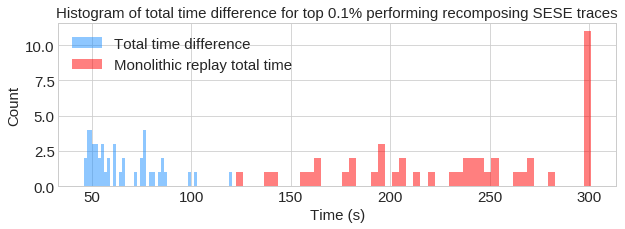

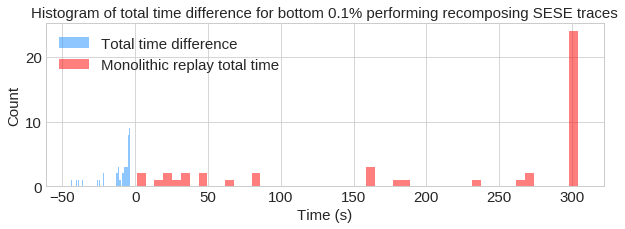

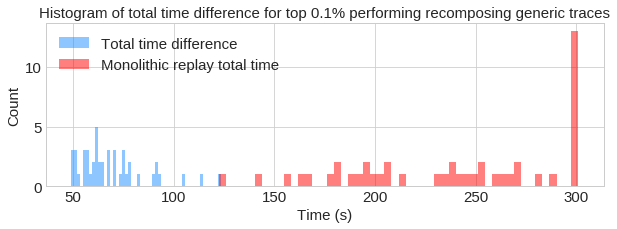

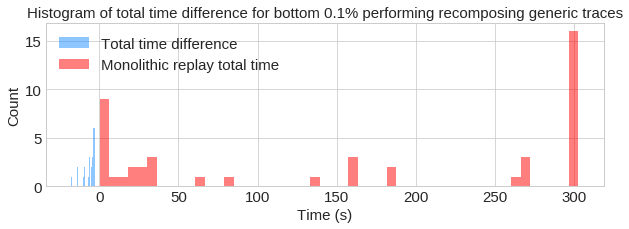

In [11]:
def analyze_top_bot_p_quantile_perf(stats_df, perf_df, p, top_title, bot_title):
    top_df = get_top_perf_reco(perf_df, 'total_time_diff', p)
    stats_df['_id'] = stats_df['SP label'] + '-' + stats_df[REPLAY_ID]
    top_df['_id'] = top_df['SP label'] + '-' + top_df[REPLAY_ID]
    top_stats_df = stats_df[stats_df['_id'].isin(top_df['_id'].values)]
    
    stats_df.drop('_id', axis=1, inplace=True)
    top_df.drop('_id', axis=1, inplace=True)
    
    assert top_df.shape[0] == top_stats_df.shape[0]

    print('(Top) Number of traces: {}'.format(top_df.shape[0]))
    print('Max time difference: {:.2f}s'.format(top_df['total_time_diff'].max() / 1000000))

    fig, ax = plt.subplots(figsize=(10, 3))

    ax.hist(top_df['total_time_diff'] / 1000000, bins=50, alpha=0.5, color='dodgerblue');
    ax.set_ylabel('Count')
    ax.set_xlabel('Time (s)')
    ax.set_title(top_title, size=15);
    ax.legend()
    ax.hist(top_stats_df['Total Time including setup (us)_mono'] / 1000000, bins=50, alpha=0.5, color='red')
    
    lgd_txt = ax.legend().get_texts()
    lgd_txt[0].set_text('Total time difference')
    lgd_txt[1].set_text('Monolithic replay total time')
    
    bot_df = get_bot_perf_reco(perf_df, 'total_time_diff', p)
    stats_df['_id'] = stats_df['SP label'] + '-' + stats_df[REPLAY_ID]
    bot_df['_id'] = bot_df['SP label'] + '-' + bot_df[REPLAY_ID]
    bot_stats_df = stats_df[stats_df['_id'].isin(bot_df['_id'].values)]
    
    stats_df.drop('_id', axis=1, inplace=True)
    bot_df.drop('_id', axis=1, inplace=True)
    
    assert bot_df.shape[0] == bot_stats_df.shape[0]

    print('(Bot) Number of traces: {}'.format(bot_df.shape[0]))
    print('Max time difference: {:.2f}s'.format(bot_df['total_time_diff'].min() / 1000000))

    fig, ax = plt.subplots(figsize=(10, 3))

    ax.hist(bot_df['total_time_diff'] / 1000000, bins=50, alpha=0.5, color='dodgerblue');
    ax.set_ylabel('Count')
    ax.set_xlabel('Time (s)')
    ax.set_title(bot_title, size=15)
    ax.legend()
    ax.hist(bot_stats_df['Total Time including setup (us)_mono'] / 1000000, bins=50, alpha=0.5, color='red')
    
    lgd_txt = ax.legend().get_texts()
    lgd_txt[0].set_text('Total time difference')
    lgd_txt[1].set_text('Monolithic replay total time');
    
    return top_df, top_stats_df, bot_df, bot_stats_df
    
p = 0.001
sese_top_title = 'Histogram of total time difference for top {}% performing recomposing SESE traces'.format(p * 100.)
sese_bot_title = 'Histogram of total time difference for bottom {}% performing recomposing SESE traces'.format(p * 100.)
gene_top_title = 'Histogram of total time difference for top {}% performing recomposing generic traces'.format(p * 100.)
gene_bot_title = 'Histogram of total time difference for bottom {}% performing recomposing generic traces'.format(p * 100.)
    
print('SESE performance')
sese_top_001_df, sese_top_001_stats_df, sese_bot_001_df, sese_bot_001_stats_df = analyze_top_bot_p_quantile_perf(sese_astar_stats_df, sese_astar_perf_df, p, sese_top_title, sese_bot_title)
print('\nGeneric performance')
gene_top_001_df, gene_top_001_stats_df, gene_bot_001_df, gene_bot_001_stats_df = analyze_top_bot_p_quantile_perf(gene_astar_stats_df, gene_astar_perf_df, p, gene_top_title, gene_bot_title) 

In [12]:
# SESE: check that the top and worst % in terms of time are also top and worst in terms of polled markings
sese_better_total_time = sese_astar_perf_df.loc[(sese_astar_perf_df['total_time_diff'] > 0),:]
sese_better_polled_trace_ids = set(sese_better_total_time[REPLAY_ID] + '-' + sese_better_total_time['SP label'])
sese_top_time_trace_ids = set(sese_top_001_df[REPLAY_ID] + '-' + sese_top_001_df['SP label'])
sese_intersect_trace_ids = sese_better_polled_trace_ids.intersection(sese_top_time_trace_ids)

print('Intersection percentage: {:.2f}%'.format(len(sese_intersect_trace_ids) / len(sese_top_time_trace_ids) * 100.))

sese_worst_total_time = sese_astar_perf_df.loc[(sese_astar_perf_df['total_time_diff'] < 0),:]
sese_worst_polled_trace_ids = set(sese_worst_total_time[REPLAY_ID] + '-' + sese_worst_total_time['SP label'])
sese_worst_time_trace_ids = set(sese_bot_001_df[REPLAY_ID] + '-' + sese_bot_001_df['SP label'])
sese_intersect_trace_ids = sese_worst_polled_trace_ids.intersection(sese_worst_time_trace_ids)

print('Intersection percentage: {:.2f}%'.format(len(sese_intersect_trace_ids) / len(sese_worst_time_trace_ids) * 100.))

# Gene: check that the top and worst % in terms of time are also top and worst in terms of polled markings
gene_better_total_time = gene_astar_perf_df.loc[(gene_astar_perf_df['total_time_diff'] > 0),:]
gene_better_polled_trace_ids = set(gene_better_total_time[REPLAY_ID] + '-' + gene_better_total_time['SP label'])
gene_top_time_trace_ids = set(gene_top_001_df[REPLAY_ID] + '-' + gene_top_001_df['SP label'])
gene_intersect_trace_ids = gene_better_polled_trace_ids.intersection(gene_top_time_trace_ids)

print('Intersection percentage: {:.2f}%'.format(len(gene_intersect_trace_ids) / len(gene_top_time_trace_ids) * 100.))

gene_worst_total_time = gene_astar_perf_df.loc[(gene_astar_perf_df['total_time_diff'] < 0),:]
gene_worst_polled_trace_ids = set(gene_worst_total_time[REPLAY_ID] + '-' + gene_worst_total_time['SP label'])
gene_worst_time_trace_ids = set(gene_bot_001_df[REPLAY_ID] + '-' + gene_bot_001_df['SP label'])
gene_intersect_trace_ids = gene_worst_polled_trace_ids.intersection(gene_worst_time_trace_ids)

print('Intersection percentage: {:.2f}%'.format(len(gene_intersect_trace_ids) / len(gene_worst_time_trace_ids) * 100.))

Intersection percentage: 100.00%
Intersection percentage: 100.00%
Intersection percentage: 100.00%
Intersection percentage: 100.00%


### Analyze the resulting alignments between top and bottom performing recomposing traces

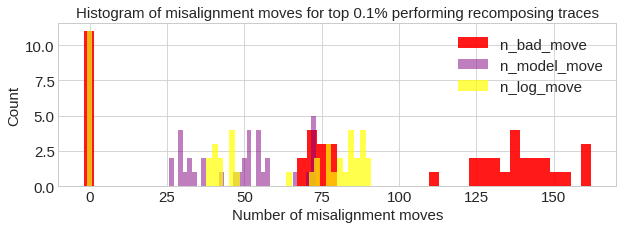

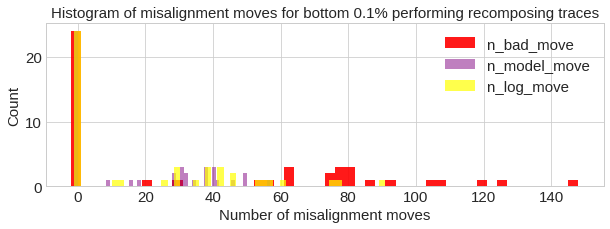

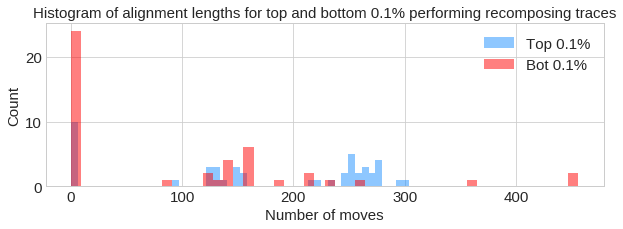

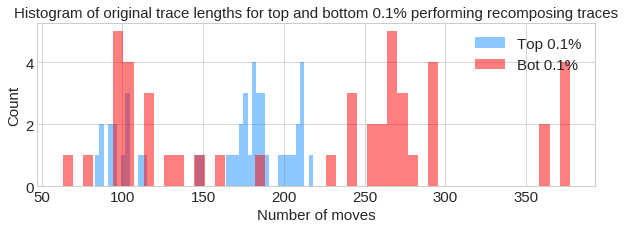

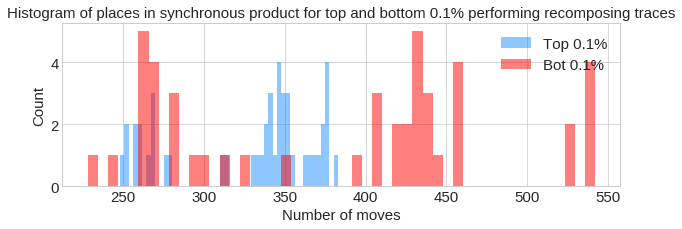

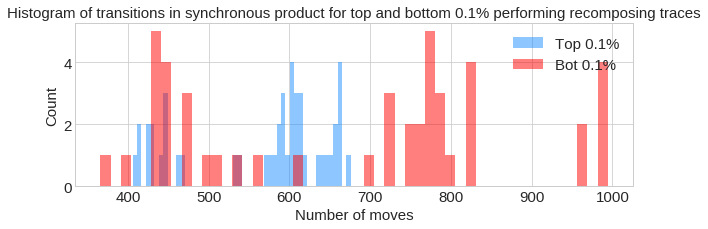

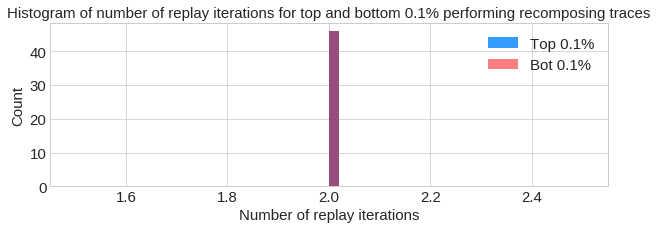

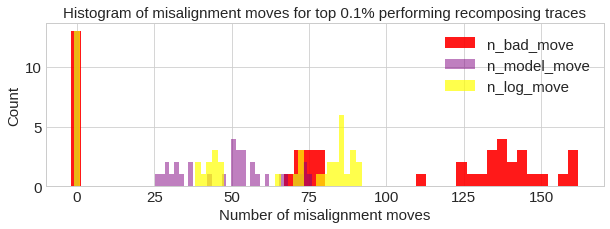

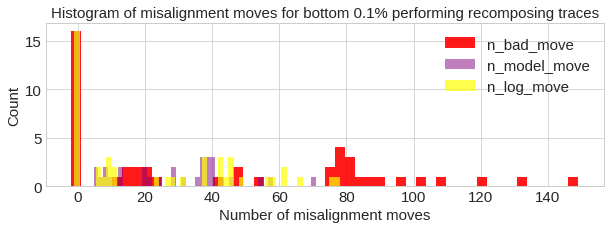

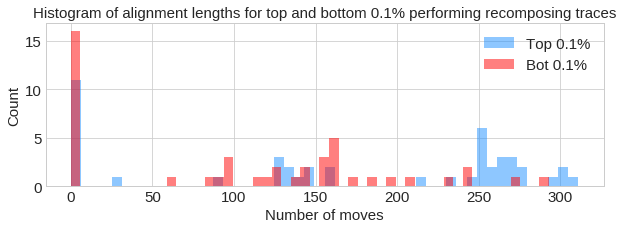

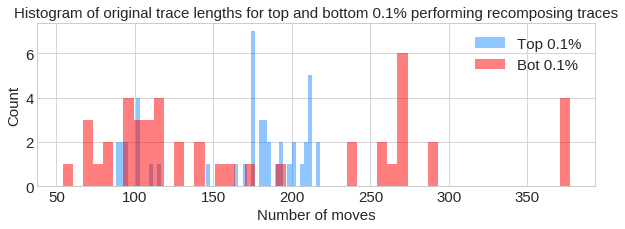

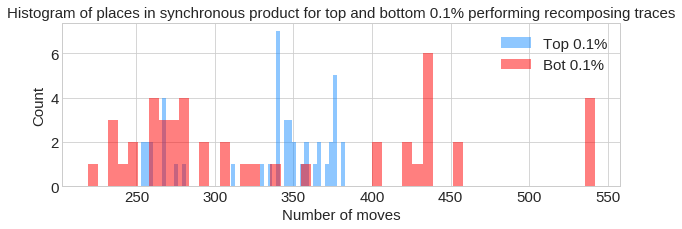

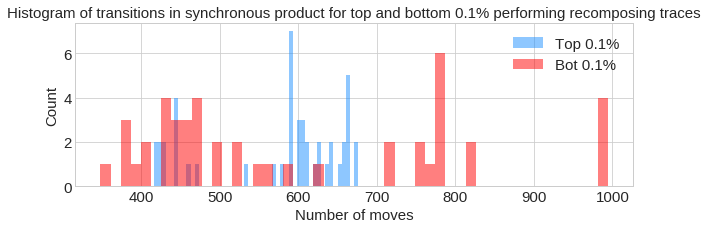

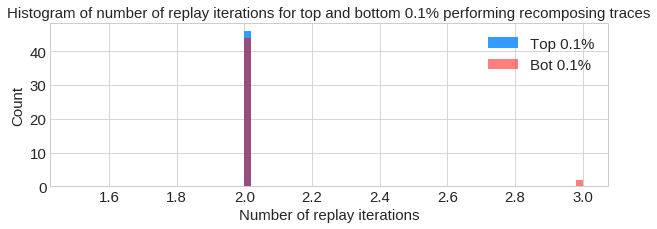

In [13]:
# in terms of alignment costs

def plot_hist_quantile_results(top_stats_df, bot_stats_df):
    fig, ax = plt.subplots(figsize=(10, 3))
    top_stats_df['n_bad_move'] = top_stats_df['n_model_move'] + top_stats_df['n_log_move']
    ax.hist(top_stats_df['n_bad_move'], bins=50, alpha=0.9, color='red')
#     ax.hist(top_stats_df['n_sync_move'], bins=50, alpha=0.5, color='lime')
#     ax.hist(top_stats_df['n_invis_move'], bins=50, alpha=0.5, color='black')
    ax.hist(top_stats_df['n_model_move'], bins=50, alpha=0.5, color='purple')
    ax.hist(top_stats_df['n_log_move'], bins=50, alpha=0.7, color='yellow')
    ax.set_xlabel('Number of misalignment moves')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title('Histogram of misalignment moves for top {}% performing recomposing traces'.format(p * 100.), size=15);

    fig, ax = plt.subplots(figsize=(10, 3))
    bot_stats_df['n_bad_move'] = bot_stats_df['n_model_move'] + bot_stats_df['n_log_move']
    ax.hist(bot_stats_df['n_bad_move'], bins=50, alpha=0.9, color='red')
#     ax.hist(bot_stats_df['n_sync_move'], bins=50, alpha=0.5, color='lime')
#     ax.hist(bot_stats_df['n_invis_move'], bins=50, alpha=0.5, color='black')
    ax.hist(bot_stats_df['n_model_move'], bins=50, alpha=0.5, color='purple')
    ax.hist(bot_stats_df['n_log_move'], bins=50, alpha=0.7, color='yellow')
    ax.set_xlabel('Number of misalignment moves')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title('Histogram of misalignment moves for bottom {}% performing recomposing traces'.format(p * 100.), size=15);

    # in terms of alignment length
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(top_stats_df['Length of the alignment found'], bins=50, alpha=0.5, color='dodgerblue')
    ax.hist(bot_stats_df['Length of the alignment found'], bins=50, alpha=0.5, color='red')
    ax.set_xlabel('Number of moves')
    ax.set_ylabel('Count')
    ax.legend()
    # modify legend labels
    lgd_texts = ax.legend().get_texts()
    lgd_texts[0].set_text('Top {}%'.format(p * 100.))
    lgd_texts[1].set_text('Bot {}%'.format(p * 100.))
    ax.set_title('Histogram of alignment lengths for top and bottom {}% performing recomposing traces'.format(p * 100.), size=15);

    # in terms of original trace length
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(top_stats_df['Length of the orignal trace'], bins=50, alpha=0.5, color='dodgerblue')
    ax.hist(bot_stats_df['Length of the orignal trace'], bins=50, alpha=0.5, color='red')
    ax.set_xlabel('Number of moves')
    ax.set_ylabel('Count')
    ax.legend()
    # modify legend labels
    lgd_texts = ax.legend().get_texts()
    lgd_texts[0].set_text('Top {}%'.format(p * 100.))
    lgd_texts[1].set_text('Bot {}%'.format(p * 100.))
    ax.set_title('Histogram of original trace lengths for top and bottom {}% performing recomposing traces'.format(p * 100.), size=15);

    # in terms of synchronous product structure
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(top_stats_df['Places in the synchronous product'], bins=50, alpha=0.5, color='dodgerblue')
    ax.hist(bot_stats_df['Places in the synchronous product'], bins=50, alpha=0.5, color='red')
    ax.set_xlabel('Number of moves')
    ax.set_ylabel('Count')
    ax.legend()    
    # modify legend labels
    lgd_texts = ax.legend().get_texts()
    lgd_texts[0].set_text('Top {}%'.format(p * 100.))
    lgd_texts[1].set_text('Bot {}%'.format(p * 100.))
    ax.set_title('Histogram of places in synchronous product for top and bottom {}% performing recomposing traces'.format(p * 100.), size=15);

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(top_stats_df['Transtions in the synchronous product'], bins=50, alpha=0.5, color='dodgerblue')
    ax.hist(bot_stats_df['Transtions in the synchronous product'], bins=50, alpha=0.5, color='red')
    ax.set_xlabel('Number of moves')
    ax.set_ylabel('Count')
    ax.legend()
    # modify legend labels
    lgd_texts = ax.legend().get_texts()
    lgd_texts[0].set_text('Top {}%'.format(p * 100.))
    lgd_texts[1].set_text('Bot {}%'.format(p * 100.))
    ax.set_title('Histogram of transitions in synchronous product for top and bottom {}% performing recomposing traces'.format(p * 100.), size=15);

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(top_stats_df['n_replay_iter'], bins=50, alpha=0.9, color='dodgerblue')
    ax.hist(bot_stats_df['n_replay_iter'], bins=50, alpha=0.5, color='red')
    ax.set_xlabel('Number of replay iterations')
    ax.set_ylabel('Count')
    ax.legend()
    # modify legend labels
    lgd_texts = ax.legend().get_texts()
    lgd_texts[0].set_text('Top {}%'.format(p * 100.))
    lgd_texts[1].set_text('Bot {}%'.format(p * 100.))
    ax.set_title('Histogram of number of replay iterations for top and bottom {}% performing recomposing traces'.format(p * 100.), size=15);
    
plot_hist_quantile_results(sese_top_001_stats_df, sese_bot_001_stats_df)
plot_hist_quantile_results(gene_top_001_stats_df, gene_bot_001_stats_df)
# all this gives motivation for the machine learning to differentiate between the different models


### Get the traces from the top and bottom performing results

In [15]:
from opyenxes.data_in.XUniversalParser import XUniversalParser
from opyenxes.data_out.XesXmlGZIPSerializer import XesXmlGZIPSerializer
from opyenxes.factory.XFactory import XFactory
import time

In [14]:
# create the logs for top and worst performing SESE
sese_top_bot_001_stats_df = pd.concat([sese_top_001_stats_df, sese_bot_001_stats_df])
gene_top_bot_001_stats_df = pd.concat([gene_top_001_stats_df, gene_bot_001_stats_df])


In [17]:
sese_top_bot_001_stats_df['useInt_reco'].unique()

array([False])

In [ ]:
net1_data_dir = '../../data/synthetic/BPI2018/net1'


def trace_has_concept_name(trace, concept_name_list):
    return trace.get_attributes()['concept:name'].get_value() in concept_name_list

def create_filtered_logs(df, data_dir):
    filtered_logs = dict()
    
    for log_name in df['log_reco'].unique():
        print('Creating subset log for {}'.format(log_name))
        subdf = df[(df['log_reco'] == log_name)]

        # read the event log
        log_filename = '{}.xes.gz'.format(log_name)
        log_fpath = os.path.join(net1_data_dir, log_filename)

        start = time.time()
        with open(log_fpath, 'r') as f:
            log = XUniversalParser().parse(f)[0]
        taken = time.time() - start
        print('Reading {} took {:.2f}s'.format(log_name, taken))

        # filter using SP label
        print('Before filtering no. of traces: {}'.format(len(log)))
        trace_ids = subdf['SP label'].values.tolist()
        print('Number of trace ids to filter: {}'.format(len(trace_ids)))
        
        filtered_traces = filter(lambda trace: trace_has_concept_name(trace, trace_ids), log)
        filtered_log = XFactory().create_log()
        # add the classifier
        filtered_log.get_classifiers().append(log.get_classifiers()[0])
        
        for trace in filtered_traces:
            filtered_log.append(trace)
        
        print('After filtering no. of traces: {}'.format(len(filtered_log)))
        
        assert len(filtered_log) == len(trace_ids)
        
        filtered_logs[log_name] = filtered_log
        
        print()
        
    return filtered_logs
        
filtered_sese_logs = create_filtered_logs(sese_top_bot_001_stats_df, net1_data_dir)
filtered_gene_logs = create_filtered_logs(gene_top_bot_001_stats_df, net1_data_dir)
   

In [ ]:
sese_trace_ids = set(sese_top_bot_001_stats_df['log_reco'] + '-' + sese_top_bot_001_stats_df['SP label'])
gene_trace_ids = set(gene_top_bot_001_stats_df['log_reco'] + '-' + gene_top_bot_001_stats_df['SP label'])

intersect = sese_trace_ids.intersection(gene_trace_ids)
print('{:.2f}%'.format(len(intersect) / len(sese_trace_ids) * 100.))

def serialize_logs(log_dict, out_dir):
    for log_name, log in log_dict.items():
        log_fpath = '{}.xes.gz'.format(log_name)
        log_fpath = os.path.join(out_dir, log_fpath)
        
        with open(log_fpath, 'w') as f:
            XesXmlGZIPSerializer().serialize(log, f)
            
sese_out_net1_data_dir = '../../data/synthetic/BPI2018/net1_inc3_sese'
gene_out_net1_data_dir = '../../data/synthetic/BPI2018/net1_inc3_gene'

if not os.path.exists(sese_out_net1_data_dir):
    os.mkdir(sese_out_net1_data_dir)
if not os.path.exists(gene_out_net1_data_dir):
    os.mkdir(gene_out_net1_data_dir)
    
serialize_logs(filtered_sese_logs, sese_out_net1_data_dir)
serialize_logs(filtered_gene_logs, gene_out_net1_data_dir)

### Check the location of the misalignment moves 

In [ ]:
sese_top_001_stats_df.head(3)

In [ ]:
sese_top_001_stats_df.loc[(sese_top_001_stats_df['SP label'] == '3393'), ['SP label', 'Exit code for alignment_reco', 'n_replay_iter', 'alignment_fpath_reco']]

alignments_inc3_sese_fpath = sese_top_001_stats_df.loc[(sese_top_001_stats_df['SP label'] == '3393'), 'alignment_fpath_reco'].values[0]

with open(alignments_inc3_sese_fpath, 'r') as f:
    alignments_inc3_sese = json.load(f)

# find alignment with representative caseid 3393
def get_alignment(alignments, caseid):
    if caseid not in alignments:
        raise ValueError('Cannot find alignment with caseid with {}'.format(caseid))
    return alignments[caseid]

alignment_3393 = get_alignment(alignments_inc3_sese, '3393')

In [ ]:
import podspy.log

In [ ]:
log_60_60_l2000_fpath = '../../data/synthetic/BPI2018/net1/net1-60-60-l2000.xes.gz'
log_60_60_l2000 = podspy.log.data_io.import_log_table(log_60_60_l2000_fpath)

In [ ]:
log_60_60_l2000_event_df = log_60_60_l2000.event_df
events_3393 = log_60_60_l2000_event_df[(log_60_60_l2000_event_df['caseid'] == '3393')]

# verify that the log projection of the alignment equals the log trace
def get_log_proj(alignment): 
    result = map(lambda triples: triples[1], alignment)
    result = filter(lambda step: step != '>>', result)
    return list(result)

def get_model_proj(alignment):
    result = map(lambda triples: triples[2], alignment)
    result = filter(lambda step: step != '>>', result)
    return list(result)

def log_proj_equals_trace(alignment, log_trace):
    log_proj = get_log_proj(alignment)
    joined = pd.DataFrame({
        'log_proj': log_proj,
        'log_trace': log_trace
    })
    joined['equal'] = joined['log_proj'] == joined['log_trace']
    return joined['equal'].all(), joined

log_proj_3393 = get_log_proj(alignment_3393['alignment'])
equal_3393, joined_3393 = log_proj_equals_trace(alignment_3393['alignment'], events_3393['concept:name'])

print('Alignment 3393 equal: {}'.format(equal_3393))